# <center> Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
!pip install phik
!pip install -U scikit-learn

In [30]:
# Загружаем библиотеки
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import lightgbm as lgb
import phik
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

In [3]:
# Функция для графиков распределения по столбцам
def plots(table,legend=True):
    for column in table.columns:
        if table[column].dtypes != 'object' :
            fig = plt.figure(figsize=(20,5))
            plt.subplot(1,2, 1)
            sns.histplot(data=table, x=column,legend=legend,stat='density', common_norm=False,kde=True)
            plt.title(f'Распределение, {column}')
            plt.ylabel('Частота')
            plt.xlabel(column)
            plt.subplot(1,2, 2)
            sns.boxplot(data=table, y=column)
            plt.title(f'Боксплот, {column}')
            plt.show()
    display(table.describe())

# Функция для графиков распределения по столбцам категориальных признаков
def plots_cat(table,filters):
    for column in table.columns:
        if table[column].dtypes == 'object':
            fig = plt.figure(figsize=(10,5))
            sns.histplot(data=table, y=column, hue=filters,kde=True)
            display(table.pivot_table(index=column, aggfunc='mean'))
            plt.ylabel(column)
            plt.xlabel('Частота')
            plt.show()
            
def plots_hist(table,filters,filters1,filters2,legend=True):
    for column in table.columns:
        if table[column].dtypes != 'object' :
            
            fig = plt.figure(figsize=(21,5))
            plt.subplot(1,3, 1)
            sns.histplot(data=table, x=column, hue=filters,legend=legend,stat='density', common_norm=False,kde=True)
            plt.title(f'Распределение, {column}')
            plt.ylabel('Плотность распределения')
            plt.xlabel(column)
            plt.subplot(1,3, 2)
            sns.histplot(data=table, x=column, hue=filters1,stat='density', common_norm=False,legend=legend,kde=True)
            plt.title(f'Распределение, {column}')
            plt.ylabel('Плотность распределения')
            plt.xlabel(column)
            plt.subplot(1,3, 3)
            sns.histplot(data=table, x=column, hue=filters2,stat='density', common_norm=False,legend=legend,kde=True)
            plt.title(f'Распределение, {column}')
            plt.ylabel('Плотность распределения')
            plt.xlabel(column)
            plt.show()
    display(table.describe())
                
def pie_plots(table):
    tables = table[table.columns]
    tables = tables.dropna()
    for column in tables.columns:
        
        if table[column].dtypes == 'object' :
            data = tables[column].value_counts()
            fig = plt.figure(figsize=(5,5))
            plt.pie(data,colors = sns.color_palette('pastel'),autopct='%1.0f%%')
            plt.title(f'Распределение, {column}')
            plt.axis('equal')
            plt.show()
            display(data.T)

## Подготовка данных

### Загружаем данные

In [4]:

try:
    autos = pd.read_csv('/datasets/autos.csv',parse_dates=['DateCrawled','DateCreated','LastSeen'])
except:
    autos = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv',parse_dates=['DateCrawled','DateCreated','LastSeen'])

display(autos.head(3))
display(autos.info())
RANDOM_STATE = 42
TEST_SIZE = 0.2

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  Repaired           283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

None

#### Вывод

- Размер исследуемого набора данных: 16 столбцов, 354369 строк
- В данных есть пропуски в столбцах: VehicleType, Gearbox, Model, FuelType, Repaired
- При загрузке изменен тип данных в столбцах: DateCrawled, DateCreated, LastSeen
- Категориальные признаки: VehicleType,	Gearbox, Model,	FuelType, Brand, Repaired

Дальше необходимо проверить данные на наличие дубликатов, обработать пропуски, проверить на аномалии и удалить признаки которые не влияют на целевой 

### Обработка аномалий

In [5]:
# Дублируем данные из исходного датасета, чтобы была возможность вернуться к исходнику
cars = autos.copy(deep=True)

In [6]:
# удалим признаки, которые не влияют на целевой признаки
drop_columns = ['DateCrawled','RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen']
cars = cars.drop(drop_columns, axis=1)

In [7]:
# Рассмотрим наличие неявных дубликатов
for column in autos.columns:
    if autos[column].dtypes=='object':
        print(f'{autos[column].unique()} - Уникальные значения в столбце ({column})')
        print();

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] - Уникальные значения в столбце (VehicleType)

['manual' 'auto' nan] - Уникальные значения в столбце (Gearbox)

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox'

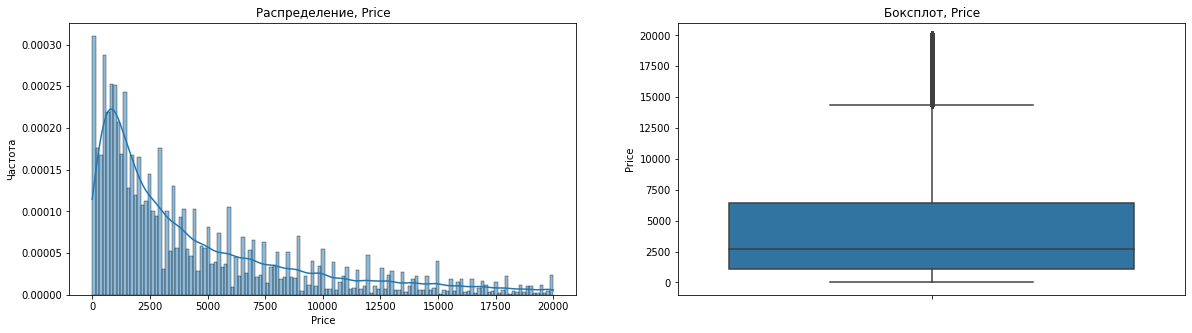

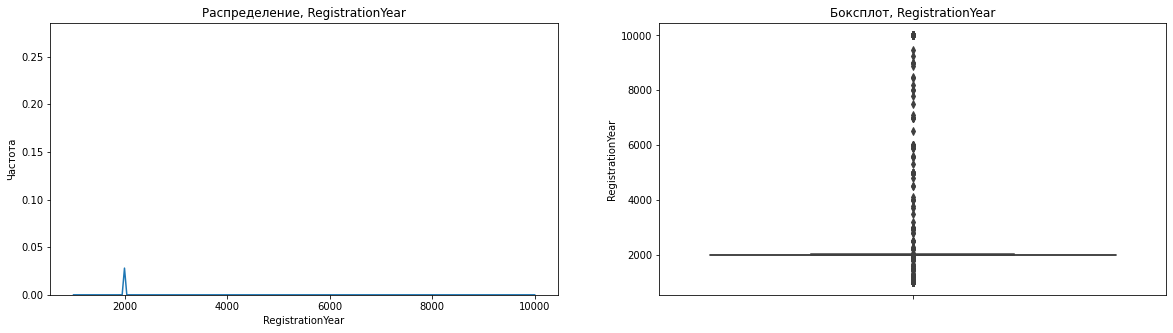

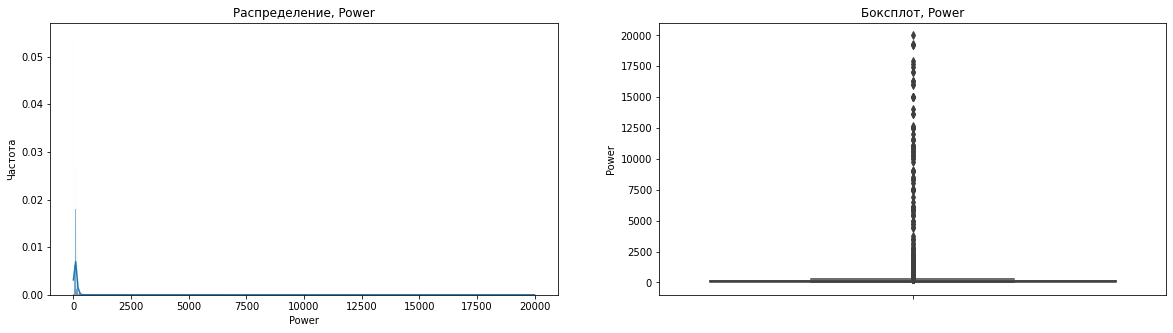

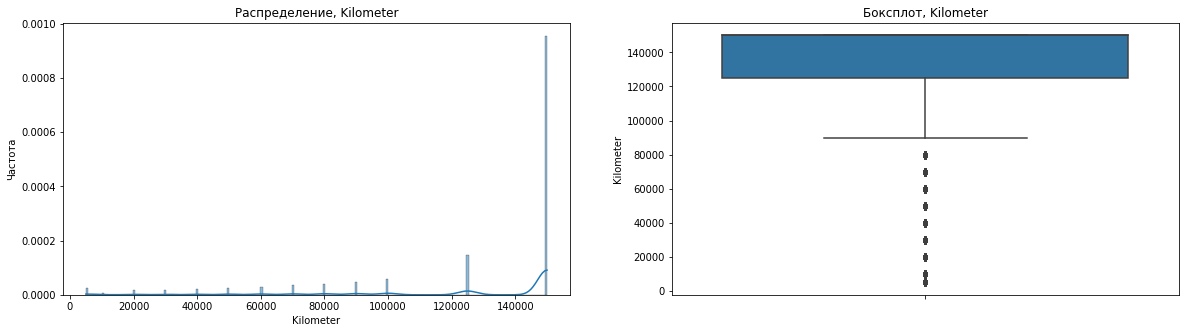

,Price,RegistrationYear,Power,Kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


In [8]:
plots(table = cars,legend=True)

- по описанию данных видим, что: 
    - в столбце с годом регистрации есть значения 1000 и 9999,
    - в столбце с мощностью двигателя есть значения 20000 и 0,
    - в столбце с стоимостью авто, минимальное значение 0


In [9]:
cars = cars[(cars['Price']>=10)]
cars = cars.query('1930 < RegistrationYear <= 2016')
cars = cars.query('10<Power <= 400')

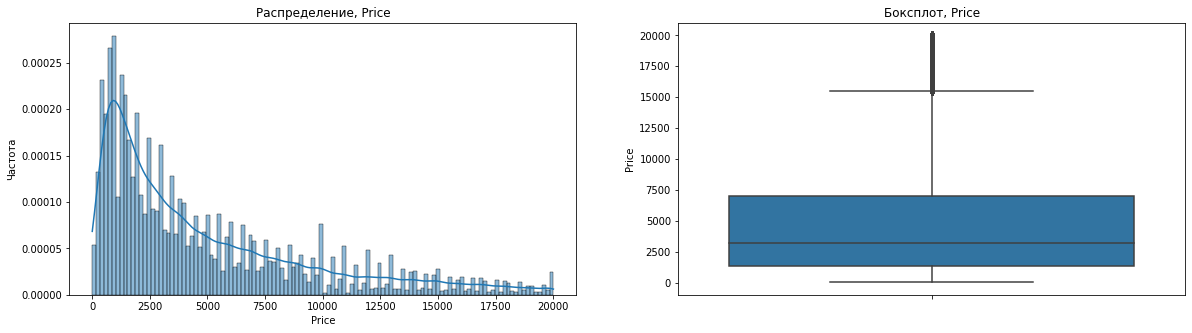

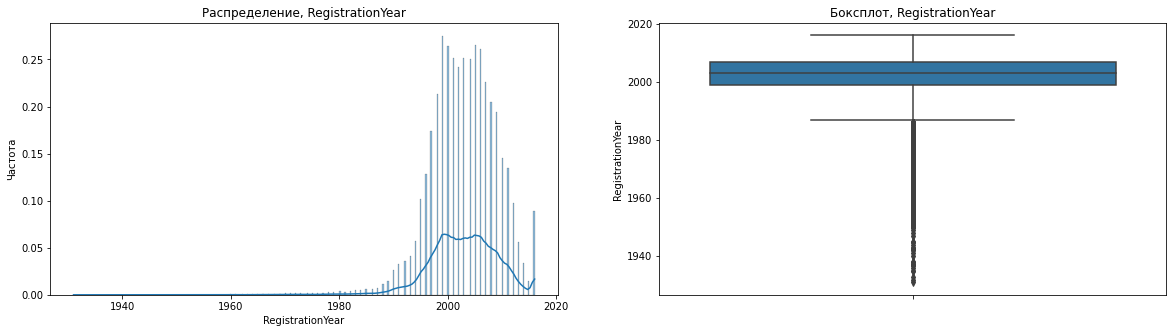

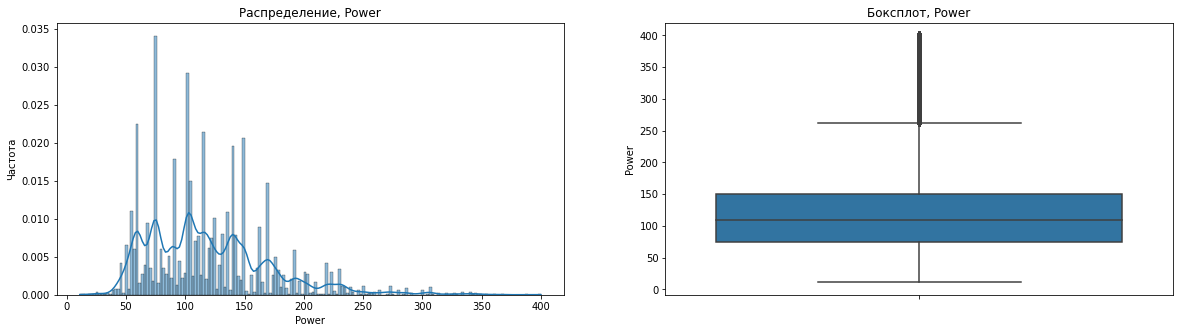

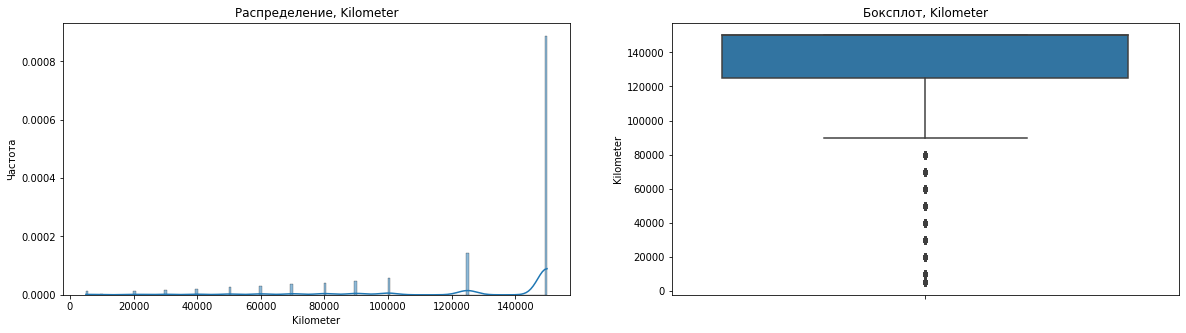

,Price,RegistrationYear,Power,Kilometer
count,295335.000000,295335.000000,295335.000000,295335.000000
mean,4857.049926,2002.825788,120.269589,128310.562581
std,4602.140880,6.519987,52.569796,36715.212795
min,10.000000,1931.000000,11.000000,5000.000000
25%,1350.000000,1999.000000,75.000000,125000.000000
50%,3200.000000,2003.000000,110.000000,150000.000000
75%,6999.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,400.000000,150000.000000


In [10]:
plots(table = cars,legend=True)

#### Вывод
- обработали аномалии в столбцах с числовыми признакми,
- получили более корреткный вид распределения и естественные значения,
- строки с аномалиями удалены

### Обработка пропусков

In [11]:
# расчитаем число пропусков по стобцам и отфильтруем столбцы 
display(cars.isna().sum().to_frame(name="empty_value"))
# процентное содержание пропусков
display(pd.DataFrame(round(cars.isna().mean()*100,1)).style.background_gradient('coolwarm'));

,empty_value
Price,0
VehicleType,10886
RegistrationYear,0
Gearbox,5317
Power,0
Model,10948
Kilometer,0
FuelType,15387
Brand,0
Repaired,42603


,0
Price,0.000000
VehicleType,3.700000
RegistrationYear,0.000000
Gearbox,1.800000
Power,0.000000
Model,3.700000
Kilometer,0.000000
FuelType,5.200000
Brand,0.000000
Repaired,14.400000


- Так как процент пропусков слишком большой, выделим пропуски отдельной категорией
- petrol и gasoline означают одно и тоже

In [12]:
cars['Model'] = cars['Model'].fillna('other')
cars['Gearbox'] = cars['Gearbox'].fillna('unknown')
cars['FuelType'] = cars['FuelType'].fillna('other')
cars['Repaired'] = cars['Repaired'].fillna('no')
cars['VehicleType'] = cars['VehicleType'].fillna('other')
cars['FuelType'] = cars['FuelType'].replace('petrol', 'gasoline')



- предположим что пропуски в столбце Repaired означают отсутствие ремнотных работ, тоесть "no"

In [13]:
# расчитаем число пропусков по стобцам и отфильтруем столбцы 
display(cars.isna().sum().to_frame(name="empty_value"));

,empty_value
Price,0
VehicleType,0
RegistrationYear,0
Gearbox,0
Power,0
Model,0
Kilometer,0
FuelType,0
Brand,0
Repaired,0


In [14]:
cars.reset_index(drop= True , inplace= True )
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295335 entries, 0 to 295334
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             295335 non-null  int64 
 1   VehicleType       295335 non-null  object
 2   RegistrationYear  295335 non-null  int64 
 3   Gearbox           295335 non-null  object
 4   Power             295335 non-null  int64 
 5   Model             295335 non-null  object
 6   Kilometer         295335 non-null  int64 
 7   FuelType          295335 non-null  object
 8   Brand             295335 non-null  object
 9   Repaired          295335 non-null  object
dtypes: int64(4), object(6)
memory usage: 22.5+ MB


#### Вывод
- после обработки данных, осталось 295335 строки и 10 столбцов
- виды распределений стали болеекорректными и читаемыми

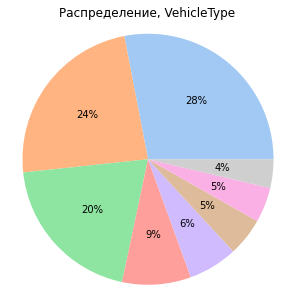

sedan          82776
small          69850
wagon          59074
bus            26163
convertible    18726
coupe          14534
other          13318
suv            10894
Name: VehicleType, dtype: int64

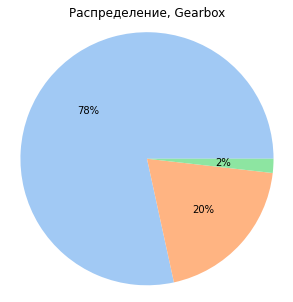

manual     231597
auto        58421
unknown      5317
Name: Gearbox, dtype: int64

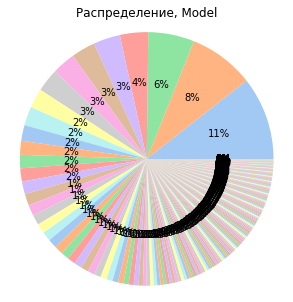

other                 31250
golf                  24657
3er                   17330
polo                  10663
corsa                 10092
                      ...  
samara                    5
serie_2                   5
serie_3                   3
rangerover                2
range_rover_evoque        2
Name: Model, Length: 249, dtype: int64

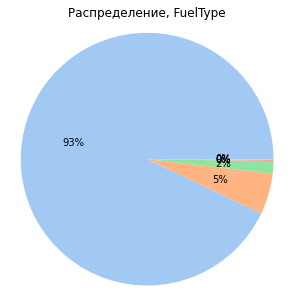

gasoline    274451
other        15473
lpg           4667
cng            481
hybrid         201
electric        62
Name: FuelType, dtype: int64

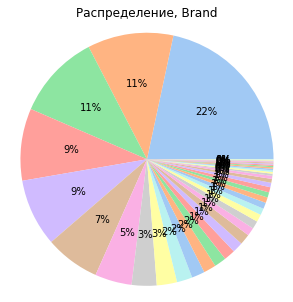

volkswagen        63928
opel              32425
bmw               32135
mercedes_benz     27216
audi              25466
ford              20672
renault           13910
peugeot            9401
fiat               7663
seat               5838
skoda              4946
mazda              4716
smart              4479
citroen            4241
nissan             4040
toyota             4009
hyundai            3104
mini               2963
volvo              2821
mitsubishi         2491
honda              2358
kia                2086
alfa_romeo         1971
suzuki             1963
sonstige_autos     1692
chevrolet          1453
chrysler           1159
dacia               800
subaru              643
daihatsu            616
porsche             581
jeep                577
saab                472
land_rover          465
jaguar              434
daewoo              409
lancia              380
rover               364
trabant             291
lada                157
Name: Brand, dtype: int64

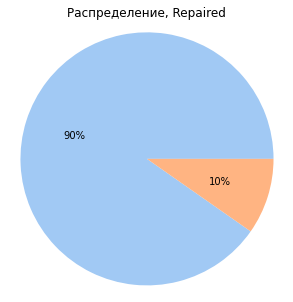

no     266644
yes     28691
Name: Repaired, dtype: int64

In [15]:
pie_plots(cars)

#### Категориальные признаки
- самый популярный кузов - седан
- больше всего авто на механической коробке
- самая популярная модель - golf
- наиболее популярный вид топлива - бензин
- самый популярный брэнд - volkswagen
- большинство автомобилей не ремонтировались

In [16]:
cars.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,gasoline,bmw,yes


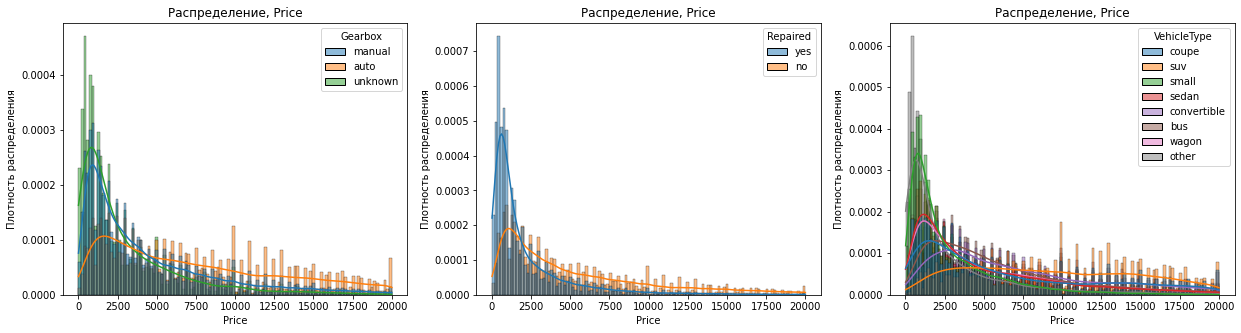

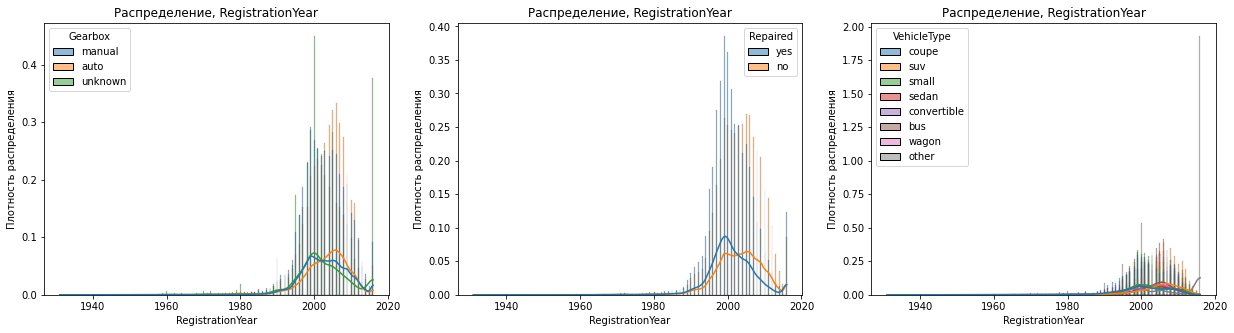

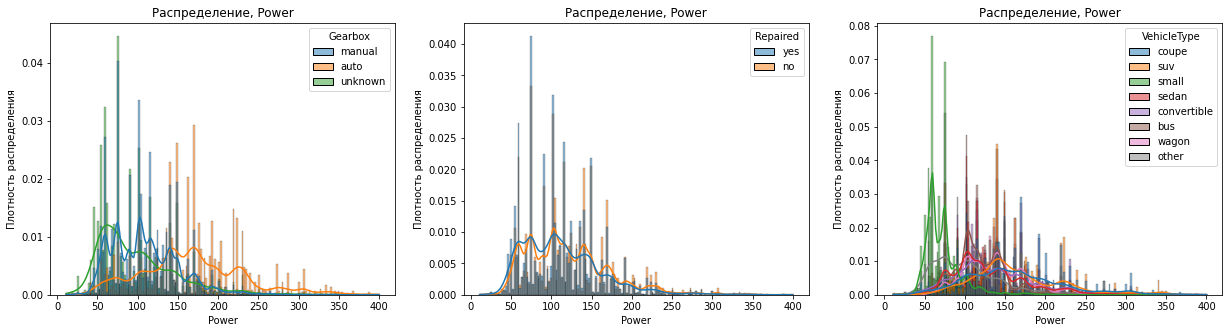

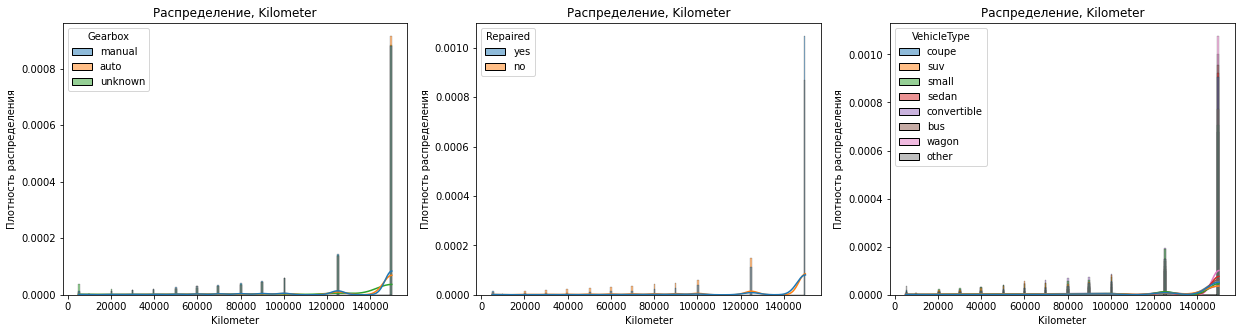

,Price,RegistrationYear,Power,Kilometer
count,295335.000000,295335.000000,295335.000000,295335.000000
mean,4857.049926,2002.825788,120.269589,128310.562581
std,4602.140880,6.519987,52.569796,36715.212795
min,10.000000,1931.000000,11.000000,5000.000000
25%,1350.000000,1999.000000,75.000000,125000.000000
50%,3200.000000,2003.000000,110.000000,150000.000000
75%,6999.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,400.000000,150000.000000


In [17]:
plots_hist(cars,filters = 'Gearbox', filters1='Repaired',filters2= 'VehicleType', legend = True )

### Вывод 
    посмотрели на данные по группам:
        - на данных видно, что автомобили с автоматической коробкой стоят дороже, 
        - ремонтированные авто значительно дешевле
        - больше всего дешевых авто в кузове small
        - преобразовал неявные дубликаты столбце с типом топлива

### Корреляционный анализ

In [18]:
display(cars.phik_matrix().style.background_gradient(cmap ='coolwarm'));

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer']


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.277822,0.609253,0.290906,0.508556,0.573618,0.315611,0.113420,0.362348,0.298739
VehicleType,0.277822,1.000000,0.193827,0.271583,0.499797,0.909892,0.178425,0.247860,0.628899,0.071846
RegistrationYear,0.609253,0.193827,1.000000,0.085402,0.267719,0.576969,0.365557,0.063495,0.380743,0.135247
Gearbox,0.290906,0.271583,0.085402,1.000000,0.476536,0.628616,0.056796,0.223845,0.520803,0.011252
Power,0.508556,0.499797,0.267719,0.476536,1.000000,0.797248,0.116637,0.107324,0.601576,0.063203
Model,0.573618,0.909892,0.576969,0.628616,0.797248,1.000000,0.441470,0.337525,0.997901,0.124251
Kilometer,0.315611,0.178425,0.365557,0.056796,0.116637,0.441470,1.000000,0.089387,0.273331,0.088685
FuelType,0.113420,0.247860,0.063495,0.223845,0.107324,0.337525,0.089387,1.000000,0.199413,0.056605
Brand,0.362348,0.628899,0.380743,0.520803,0.601576,0.997901,0.273331,0.199413,1.000000,0.080365
Repaired,0.298739,0.071846,0.135247,0.011252,0.063203,0.124251,0.088685,0.056605,0.080365,1.000000


#### Вывод ####
- мультиколлениарности c целевым признаком Price не обнаружено
- связь между данными прослеживается, можно приступать к обучению моделей

## Обучение моделей

In [19]:
def model_stats(pipeline, parameters, features_train, target_train, cv):
    # Инициализация RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=parameters,
        n_iter=10, 
        cv=cv,  
        scoring='neg_root_mean_squared_error',  
        n_jobs=-1,  
        verbose=1, 
        random_state=42  
    )
    random_search.fit(features_train, target_train)
  

    # Время обучения лучшей модели
    best_model = random_search.best_estimator_
    start_time = time.time()
    best_model.fit(features_train, target_train)
    best_training_time = time.time() - start_time

    # Время предсказания лучшей модели
    start_time = time.time()
    predictions = best_model.predict(features_train)
    prediction_time = time.time() - start_time

    # RMSE из кросс-валидации
    rmse = round(-random_search.best_score_, 2)

    # Сбор статистики
    stat_data = [best_training_time, prediction_time, rmse]

    return stat_data, random_search

In [20]:
price_features = cars.drop(columns='Price')
price = cars['Price']
cat_features = ['RegistrationYear','VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
num_features =  ['Power', 'Kilometer']
# Разделение на тренировочный, тестовый и валидационный наборы данных
X_train, X_test, y_train, y_test = train_test_split(price_features, price, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

print(f'Размер обучающей выборки:{y_train.shape[0]}')
print(f'Размер тестовой выборки:{y_test.shape[0]}')
print(cat_features)

Размер обучающей выборки:236268
Размер тестовой выборки:59067
['RegistrationYear', 'VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [21]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first',handle_unknown='ignore')
        )
    ]
)  ;

In [22]:
col_transformer_lr = ColumnTransformer(
    transformers=[
        ('ohe', ohe_pipe, cat_features),
        ('scaler', StandardScaler(), num_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

col_transformer_gb = ColumnTransformer(
    transformers=[
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features),
        ('scaler', StandardScaler(), num_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

### Linear

In [24]:
linear= LinearRegression()
# Сетка гиперпараметров для подбора

pipeline_linear = Pipeline(steps=[
    ('preprocessor', col_transformer_lr),
    ('linear', linear)
])
params_linear = {
    'linear__fit_intercept': [True, False]
}


linear_stat, linear_grid = model_stats(pipeline_linear, 
                                       params_linear,
                                      X_train, y_train, 
                                      cv=3)


print("Linear Regression - лучшие параметры:", linear_grid.best_params_)
print("Linear Regression - лучшая модель:", linear_grid.best_estimator_)
print("Linear Regression - статистика:", linear_stat)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 2 candidates, totalling 6 fits


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categor

Linear Regression - лучшие параметры: {'linear__fit_intercept': True}
Linear Regression - лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['RegistrationYear',
                                                   'VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                        

### CatBoost


In [25]:
catboost_model = CatBoostRegressor(random_state=RANDOM_STATE, silent=True)
params_catboost = {
    'catboost__learning_rate': [0.1],
    'catboost__iterations': [8, 34, 96],
    'catboost__max_depth': [10, 23]
}
pipeline_catboost = Pipeline(steps=[
    ('preprocessor', col_transformer_gb),
    ('catboost', catboost_model)
])
catboost_stat, catboost_grid = model_stats(pipeline_catboost, 
                                           params_catboost,
                                           X_train, y_train, 
                                           cv=3)
print("CatBoost - лучшие параметры:", catboost_grid.best_params_)
print("CatBoost - лучшая модель:", catboost_grid.best_estimator_)
print("CatBoost - статистика:", catboost_stat)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrappe

CatBoost - лучшие параметры: {'catboost__max_depth': 10, 'catboost__learning_rate': 0.1, 'catboost__iterations': 96}
CatBoost - лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['RegistrationYear',
                                                   'VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('scaler', StandardScaler(),
                                                  ['Power', 'Kilometer'])],
                                   verbose_feature_names_out=False)),


### LightGBM

In [26]:
# Параметры модели
lgbm_model = LGBMRegressor(random_state=RANDOM_STATE)
params_lgbm = {
    'lgbm__learning_rate': [0.1],
    'lgbm__n_estimators': [50, 100, 200],
    'lgbm__max_depth': [10, 20, 30]
}
pipeline_lgbm = Pipeline(steps=[
    ('preprocessor', col_transformer_gb),
    ('lgbm', lgbm_model)
])
lgbm_stat, lgbm_grid = model_stats(pipeline_lgbm, 
                                   params_lgbm,
                                   X_train, y_train, 
                                   cv=3)
print("LightGBM - лучшие параметры:", lgbm_grid.best_params_)
print("LightGBM - лучшая модель:", lgbm_grid.best_estimator_)
print("LightGBM - статистика:", lgbm_stat)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


LightGBM - лучшие параметры: {'lgbm__n_estimators': 200, 'lgbm__max_depth': 20, 'lgbm__learning_rate': 0.1}
LightGBM - лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['RegistrationYear',
                                                   'VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                                                 ('scaler', StandardScaler(),
                                                  ['Power', 'Kilometer'])],
                                   verbose_feature_names_out=False)),
         

## Анализ моделей

In [27]:
stats_data= pd.DataFrame([linear_stat, catboost_stat, lgbm_stat], 
             columns=['Время обучения', 'Время предсказания', 'RMSE'], 
                      index=['Linear','CatBoost','LightGBM'])
stats_data

,Время обучения,Время предсказания,RMSE
Linear,29.977707,0.634411,2067.20
CatBoost,6.574759,0.757818,1695.81
LightGBM,11.402580,3.391383,1628.66


### ВЫВОД
- как можем наблюдвать из таблицы, модель LightGBM дает наибольшую точность предсказаний, но обучение занимает сильно больше времени
- учитывая , что результат CatBoost не значительно хуже , но при этом времени на обучение затрачивается сильно меньше
 

### Проверим лучшую модель на тестовых данных

In [31]:
test_predict = catboost_grid.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(test_rmse)

1700.7267015740965


- Как видим RMSE на тестовых данных равен 1700 , что удовлетворяет условию заказчика

## ВЫВОД
- Загрузили данные: 
    - Размер исследуемого набора данных: 16 столбцов, 354369 строк
    - В данных есть пропуски в столбцах: VehicleType, Gearbox, Model, FuelType, Repaired
    - При загрузке изменен тип данных в столбцах: DateCrawled, DateCreated, LastSeen
    - Категориальные признаки: VehicleType,	Gearbox, Model,	FuelType, Brand, Repaired
- Обработали данные:
    - обработали аномалии в столбцах с числовыми признакми,
    - получили более корреткный вид распределения и естественные значения,
    - строки с аномалиями удалены
    - заменили пропуски на заглушки
- Посмотрели на данные по группам:
    - на данных видно, что автомобили с автоматической коробкой стоят дороже, 
    - ремонтированные авто значительно дешевле
    - больше всего дешевых авто в кузове small
- мультиколлениарности c целевым признаком Price не обнаружено
- связь между данными прослеживается, можно приступать к обучению моделей


- **По результатам работы, лучше всего для этой задачи подходит Catboost,
так как он дает хороший результат с адекватным временем обучения на большом обьеме данных**